In [8]:
#Choose GPUs and CPUs

#If want to choose GPU to use
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"

import tensorflow as tf
from keras import backend as K

GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Reload all data from before

In [6]:
from keras import backend as K
from keras.datasets import mnist
import keras

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_dataset = x_train.astype('float32')
test_dataset = x_test.astype('float32')
train_dataset /= 255
test_dataset /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(y_train, num_classes)
test_labels = keras.utils.to_categorical(y_test, num_classes)


('train_dataset shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


# Try basic NN, no convolutional layer

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#Reshape to 1D array for CNN
dims=train_dataset.shape
print (dims)
trainee=train_dataset.reshape(dims[0],dims[1]*dims[2])
dims=test_dataset.shape
testee=test_dataset.reshape(dims[0],dims[1]*dims[2])
print (trainee.shape)

K.clear_session()
np.random.seed(123)
model=Sequential()
model.add(Dense(800, input_shape=(784,), activation='relu')) #Contains 2 layers, input layer
                #with 784=shape of object and 1000 node hidden layer
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

hist=model.fit(trainee, train_labels, batch_size=200, verbose=1, epochs=20, validation_split = 0.1)
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

(60000, 28, 28, 1)
(60000, 784)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 800)               628000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               320400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               80200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)    

# O.K now try CNN

In [22]:
dims=train_dataset.shape
print (dims)
trainee=train_dataset.reshape(dims[0],dims[1],dims[2],1)
dims=test_dataset.shape
testee=test_dataset.reshape(dims[0],dims[1],dims[2],1)
print (trainee.shape)


from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import backend as K
from keras.utils import to_categorical

K.clear_session()
np.random.seed(123)
model=Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1),data_format='channels_last'))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())


checkpoints=keras.callbacks.ModelCheckpoint('tmp_models/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history=model.fit(trainee, train_labels, batch_size=100, verbose=1, epochs=10, validation_split = 0.1, callbacks=[checkpoints])
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10

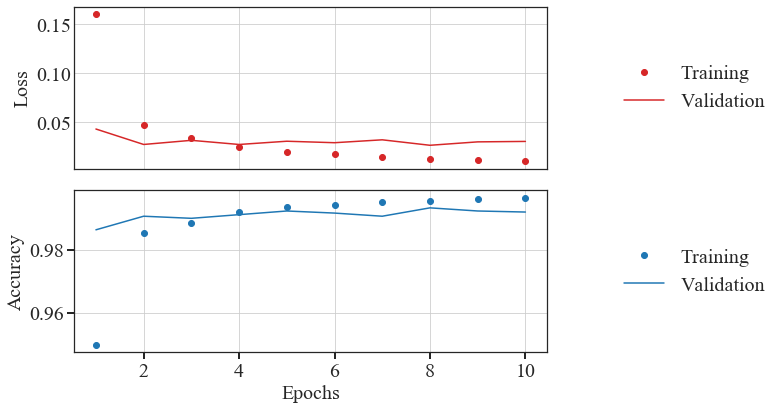

In [23]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(2, sharex=True, figsize=(8, 6))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))


axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)

In [25]:
from keras.models import Model, load_model
model=load_model('tmp_models/weights.08.hdf5')
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

10000/10000 [==============================] - 2s 168us/step
[0.019874092621581803, 0.99399999999999999]
